Obtención de los datos

In [1]:
import pandas as pd

# Cargar datos
path='C:/4_F5/011_proyecto_ml/'


df = pd.read_csv(path + '/airline_passenger_satisfaction.csv')

#Se elimina la primera columna que era el subíndice del csv
df = df.iloc[:, 1:] 
df=df.drop(columns='id') #no sé si al final quito el id porque me estorba

In [2]:
#Hay que crear una parte que sea 'test'
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=22 )

# test_size=0.2, este parámetro indica que deseas que el 20% de los datos se utilicen como conjunto de prueba y el 80% como conjunto de entrenamiento. 
# random_state=22 Este parámetro establece una semilla para el generador de números aleatorios que se usa para realizar la división. Esto asegura que cada vez que ejecutes el código, obtendrás la misma división de los datos en conjuntos de entrenamiento y prueba. Usar un valor de random_state fijo es una buena práctica cuando quieres que tus resultados sean reproducibles.

train.to_csv(path+'df_train.csv', index=False)
test.to_csv(path+'df_test.csv', index=False)
#Este test no lo tocamos hasta el final

3. Exploración y visualización de Datos

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

In [4]:
print(f'\n\nEl DF tiene {df.shape[0]:,} filas')
print(f'El DF tiene {df.shape[1]} columnas')



El DF tiene 103,904 filas
El DF tiene 23 columnas


Voy a tratar los missings

In [5]:
# Comprobar cuántos valores missing existen en el DataFrame por variable

nulos={'conteo_nulos':df.isnull().sum(),'proporcion%':round(df.isnull().sum()/df.shape[0]*100, 3)}

df_nulos=pd.DataFrame(data=nulos)
print(df_nulos)

                                   conteo_nulos  proporcion%
Gender                                        0        0.000
Customer Type                                 0        0.000
Age                                           0        0.000
Type of Travel                                0        0.000
Class                                         0        0.000
Flight Distance                               0        0.000
Inflight wifi service                         0        0.000
Departure/Arrival time convenient             0        0.000
Ease of Online booking                        0        0.000
Gate location                                 0        0.000
Food and drink                                0        0.000
Online boarding                               0        0.000
Seat comfort                                  0        0.000
Inflight entertainment                        0        0.000
On-board service                              0        0.000
Leg room service        

Antes de convertir las variables hay que tratar los 'missings'.

Que según hemos concluido, tantos los valores '0' como los 'espacios en blanco' son 'missing' y los vamos a eliminar. ---->Al final hemos decidido que los '0' sí se van a tener en cuenta.

In [6]:
# Primero elimino los 'missings'
df = df.dropna(how='any')

print(f'\n\nEl DF tiene {df.shape[0]:,} filas')


# Compruebo que se ha eliminado
missing={'conteo_nulos':df.isnull().sum(),'proporcion%':round(df.isnull().sum()/df.shape[0]*100, 3)}
df_coun_missing=pd.DataFrame(data=nulos)
print(df_coun_missing)



El DF tiene 103,594 filas
                                   conteo_nulos  proporcion%
Gender                                        0        0.000
Customer Type                                 0        0.000
Age                                           0        0.000
Type of Travel                                0        0.000
Class                                         0        0.000
Flight Distance                               0        0.000
Inflight wifi service                         0        0.000
Departure/Arrival time convenient             0        0.000
Ease of Online booking                        0        0.000
Gate location                                 0        0.000
Food and drink                                0        0.000
Online boarding                               0        0.000
Seat comfort                                  0        0.000
Inflight entertainment                        0        0.000
On-board service                              0        0.

Separo la Variable Objetivo, 'Y', de las Variables predictoras 'X'

In [7]:
#En este dataframe guarda la variable Objetivo, 'Y'
y = df['satisfaction']

In [8]:
#En esta dataframe 'x' se guardan las variables predictoras
x=df.drop(columns=['satisfaction'])

print(f'Las variables son {len(x.columns)}:\n\n' + '\n'.join(x.columns) + '\n')


Las variables son 22:

Gender
Customer Type
Age
Type of Travel
Class
Flight Distance
Inflight wifi service
Departure/Arrival time convenient
Ease of Online booking
Gate location
Food and drink
Online boarding
Seat comfort
Inflight entertainment
On-board service
Leg room service
Baggage handling
Checkin service
Inflight service
Cleanliness
Departure Delay in Minutes
Arrival Delay in Minutes



Codifico 'Y' en binario, aunque a veces hay modelos que trabajan igualmente bien sin codificar.

In [9]:
# Codificación de la variable objetivo

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_le = le.fit_transform(y)


In [10]:
# Conteo de los valores por cada columna ----> Hacer bucle para ver si hay columnas que estén desbalanceadas.
# Para ver qué variables hay que escalar

df['Customer Type'].value_counts()

Customer Type
Loyal Customer       84662
disloyal Customer    18932
Name: count, dtype: int64

In [11]:
#Ahora elimino los '0' pero de las columnas categóricas ordinales
# -->Ya no, hemos decidido dejarlos !!!!!!



Voy a separar las variables, por un lado según sean categóricas(binarias, ordinales..) y por otro las numéricas

· Categóricas

· Numéricas

Porque a veces un modelo va a trabajar mejor sólo con las categóricas o sólo con las numéricas.
Además, es conveniente escalar las variables munéricas (ya sean por cambios de escala o por magnitud, o incluso 'normalizarlas')

Detecto las variables categóricas para separarlas de las numéricas, porque es conveniente para codificar tanto las categóricas ordinales(que en este caso no es necesario porque ya están del 0 al 5) y las categóricas binarias, por un lado, y escalar las numéricas.

Filtro en el dataframe 'X' las variables categóricas y las variables numéricas.

In [12]:
import pandas as pd
from pandas.api.types import is_categorical_dtype

# Para detectar me da igual usar 'X' o usar 'X_TRAIN' porque sólo quiero el nombre de las columans
# Función para detectar variables categóricas ordinales
def detectar_variables_ordinales(x):
    ordinal_columns = []

    for column in x.columns:
        # verificar si la columna es numérica
        if pd.api.types.is_numeric_dtype(x[column]):
            # obtener valores únicos
            unique_values = x[column].unique()
            # verificar si todos los valores están en el rango [1,5]
            if set(unique_values).issubset({0, 1, 2, 3, 4, 5}):
                ordinal_columns.append(column)

    
    return ordinal_columns




variables_ordinales = detectar_variables_ordinales(x)

print(f'Variables categóricas ordinales: {len(variables_ordinales)}\n\n' + '\n'.join(variables_ordinales) + '\n')


# Resultado:
# Variables categóricas ordinales: ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']
# Ya no !!!!!  ----> De esas variables hay que quitar los '0' porque hemos decidido que son missing. Antes de hacer el one-hot-encoding


Variables categóricas ordinales: 14

Inflight wifi service
Departure/Arrival time convenient
Ease of Online booking
Gate location
Food and drink
Online boarding
Seat comfort
Inflight entertainment
On-board service
Leg room service
Baggage handling
Checkin service
Inflight service
Cleanliness



In [13]:
# Variables que son categóricas binarias y categóricas no ordinales
import pandas as pd

def detectar_variables_categoricas(x):
    categorias_columns = []

    for column in x.columns:
        # Verificar si la columna no es numérica
        if not pd.api.types.is_numeric_dtype(x[column]):
            # Obtener el número de categorías únicas
            unique_values = x[column].nunique()
            # Se puede agregar un límite arbitrario si se desea,
            # por ejemplo, menos de 10 categorías únicas
            if unique_values < 10:
                categorias_columns.append(column)

    return categorias_columns

# Supongamos que tienes un DataFrame df
variables_categoricas = detectar_variables_categoricas(x)

print(f'Variables categóricas binarias y categóricas no ordinales: {len(variables_categoricas)}\n\n' + '\n'.join(variables_categoricas) + '\n')


Variables categóricas binarias y categóricas no ordinales: 4

Gender
Customer Type
Type of Travel
Class



Junto el nombre de las variables categóricas (ya sean binarias, no ordinales y ordinales)

In [14]:
#Filtro para quedarme con las numéricas, las que voy a escalar

# Primero detecto las columnas que tienen solo valores de 0 y 1
""" binary_cols = x_encoded.columns[x_encoded.nunique() == 2]

# Luego detecto las columnas ordinales (2 a 5)
ordinal_cols = x_encoded.columns[(x_encoded.nunique() > 1) & (x_encoded.nunique() <= 5)] """

# Ambas categóricas las junto 
categorical_cols = list(variables_categoricas) + list(variables_ordinales)



print(f'Variables categóricas en total: {len(categorical_cols)}\n\n' + '\n'.join(categorical_cols) + '\n')


Variables categóricas en total: 18

Gender
Customer Type
Type of Travel
Class
Inflight wifi service
Departure/Arrival time convenient
Ease of Online booking
Gate location
Food and drink
Online boarding
Seat comfort
Inflight entertainment
On-board service
Leg room service
Baggage handling
Checkin service
Inflight service
Cleanliness



Ahora encuentro las variables numéricas y las filtro

In [15]:
data_cat=x[categorical_cols]
data_num=x.drop(columns=categorical_cols)

print(f'Variables numéricas: {len(data_num.columns)}\n\n' + '\n'.join(data_num.columns) + '\n')


Variables numéricas: 4

Age
Flight Distance
Departure Delay in Minutes
Arrival Delay in Minutes



Ahora hay que sacar el 'train' y 'test' tanto de 'Y' como de 'X'

In [16]:
# Separa el dataframe en partes de entrenamiento y prueba, tanto en 'X' como en 'Y'
x_train, x_test, y_train, y_test = train_test_split(x, y_le, test_size=0.3, random_state=42)

Antes de hacer la matriz de correlación, hay que convertir las columnas que son 'object' a binarias.

**One-Hot Encoding es generalmente preferido cuando no hay un orden inherente en las categorías. De esta manera, me aseguro de que el modelo no asuma relaciones incorrectas entre las categorías.

**Label Encoding podría usarse si hay un orden claro entre las categorías

In [27]:
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
# Separar la variable objetivo antes de la codificación, la llamo 'y'.
# Si no la separo todavía, la va a codificar, lo cual no sé si conviene por el momento.


#-- Codificar solo las variables categóricas--

# Variables categóricas
encoder_cat = ce.OneHotEncoder(use_cat_names=True)
x_train_cat_encod= encoder_cat.fit_transform(x_train)
#Hay que aplicar la transformación a la parte 'test'


# Variables categóricas ordinales -----> no haría falta
# Crear OrdinalEncoder
encoder_ord = OrdinalEncoder()
# Aplicar OrdinalEncoder a múltiples variables categóricas ordinales.
# Machaco la variable x_train_cat que la recojo de la codificación anterior.
x_train_ord_encod= pd.DataFrame(encoder_ord.fit_transform(x_train_cat_encod), columns=x_train_cat_encod.columns)
#Hay que aplicar la transformación a la parte 'test'


# Concatenar la columna 'satisfaccion' de nuevo al DataFrame codificado


""" # Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=42)

# Guardar datos en ficheros
path='C:/4_F5/011_proyecto_ml/'
x_train.to_csv(path + '/x_train.csv')
x_test.to_csv(path + '/x_test.csv')
y_train.to_csv(path + '/y_train.csv')
y_test.to_csv(path + '/y_test.csv')
 """

print(x_train_cat_encod.head())

        Gender_Male  Gender_Female  Customer Type_Loyal Customer  \
66607             1              0                             1   
100257            0              1                             0   
96338             0              1                             1   
96765             0              1                             1   
331               0              1                             1   

        Customer Type_disloyal Customer       Age  \
66607                                 0  0.041137   
100257                                1  0.372002   
96338                                 0  0.967561   
96765                                 0  0.901388   
331                                   0  0.305829   

        Type of Travel_Business travel  Type of Travel_Personal Travel  \
66607                                1                               0   
100257                               1                               0   
96338                                1            


Cuando tienes un DataFrame con columnas categóricas y categóricas ordinales, es importante elegir el método de codificación adecuado que preserve la naturaleza ordinal de la columna.

¿Por qué este orden es importante?

Consistencia: Al separar primero X e y y luego hacer el split, garantizas que las filas correspondientes de X e y coincidan exactamente en los conjuntos de entrenamiento y prueba.

Evitar filtraciones de datos: Si haces el split antes de separar X e y, podrías accidentalmente introducir fugas de datos o inconsistencias, lo que podría afectar la capacidad del modelo para generalizar.

* Primero separas la 'y' de las variables predictoras 'x'.
* Luego El split de tanto 'y' como 'x' con su correspondiente 'train' y 'test'
* Finalmente voy a escalar las numéricas: Después de realizar el split, ajustas el escalador (Scaler) solo con el conjunto de entrenamiento (X_train). Esto asegura que las estadísticas de escalado (media, desviación estándar, etc.) no estén influenciadas por los datos de prueba.
* Aplicar la transformación de escalado al conjunto de prueba:Una vez que el escalador se ha ajustado al conjunto de entrenamiento, usas ese mismo escalador para transformar el conjunto de prueba (X_test). Esto asegura que ambos conjuntos sean escalados de manera consistente


In [30]:
#Primero separas la 'y' de las variables predictoras 'x'
#Luego El split de tanto 'y' como 'x' con su correspondiente 'train' y 'test'
#Finalmente voy a escalar las numéricas: Después de realizar el split, ajustas el escalador (Scaler) solo con el conjunto de entrenamiento (X_train). Esto asegura que las estadísticas de escalado (media, desviación estándar, etc.) no estén influenciadas por los datos de prueba.
#Aplicar la transformación de escalado al conjunto de prueba:Una vez que el escalador se ha ajustado al conjunto de entrenamiento, usas ese mismo escalador para transformar el conjunto de prueba (X_test). Esto asegura que ambos conjuntos sean escalados de manera consistente
from sklearn.preprocessing import StandardScaler
# Crea un objeto StandardScaler y ajusta los parámetros de escalado con la parte de entrenamiento
scaler = StandardScaler()
x_train_num_scaled = scaler.fit_transform(x_train_cat_encod)

""" # Aplica los parámetros de escalado aprendidos a la parte de 'test'
x_test_num_scaled = scaler.transform(x_test[data_num.columns]) #devuelve un array de arrays
 """
print(x_train_cat_encod.head())


        Gender_Male  Gender_Female  Customer Type_Loyal Customer  \
66607             1              0                             1   
100257            0              1                             0   
96338             0              1                             1   
96765             0              1                             1   
331               0              1                             1   

        Customer Type_disloyal Customer       Age  \
66607                                 0  0.041137   
100257                                1  0.372002   
96338                                 0  0.967561   
96765                                 0  0.901388   
331                                   0  0.305829   

        Type of Travel_Business travel  Type of Travel_Personal Travel  \
66607                                1                               0   
100257                               1                               0   
96338                                1            

La razón es que, en general, deseas mantener la separación entre los datos de entrenamiento y los datos de prueba, incluso después de la escalado. De esta manera, puedes asegurarte de que el modelo de machine learning se entrena y se evalúa correctamente.

In [29]:
print(x_train)

        Gender      Customer Type       Age   Type of Travel     Class  \
66607     Male     Loyal Customer  0.041137  Business travel  Business   
100257  Female  disloyal Customer  0.372002  Business travel  Business   
96338   Female     Loyal Customer  0.967561  Business travel  Business   
96765   Female     Loyal Customer  0.901388  Business travel  Business   
331     Female     Loyal Customer  0.305829  Business travel  Business   
...        ...                ...       ...              ...       ...   
6281    Female     Loyal Customer  1.430773  Personal Travel  Eco Plus   
55054     Male     Loyal Customer -0.025037  Business travel  Business   
77048   Female  disloyal Customer -0.355902  Business travel  Business   
861     Female     Loyal Customer -1.017634  Business travel  Business   
15832   Female     Loyal Customer  0.835215  Business travel       Eco   

        Flight Distance  Inflight wifi service  \
66607          1.793767                      4   
100257     

In [19]:

# En 'train' cojo las columnas numéricas sin escalar y las reemplazo con las columnas numéricas escaladas. 
# Por lo que ya me queda todo 'x_train' junto y escalado
#x_train[data_num.columns] = x_train_num_scaled
print(x_train)

x_train.to_csv(path +   '/x_train_scaled.csv')

# En 'test' cojo las columnas numéricas sin escalar y las reemplazo con las columnas numéricas escaladas.
# Por lo que ya me queda todo 'x_test' junto y escalado
x_test[data_num.columns] = x_test_num_scaled
x_test.to_csv(path + '/x_test_scaled.csv')



        Gender      Customer Type       Age   Type of Travel     Class  \
66607     Male     Loyal Customer  0.041137  Business travel  Business   
100257  Female  disloyal Customer  0.372002  Business travel  Business   
96338   Female     Loyal Customer  0.967561  Business travel  Business   
96765   Female     Loyal Customer  0.901388  Business travel  Business   
331     Female     Loyal Customer  0.305829  Business travel  Business   
...        ...                ...       ...              ...       ...   
6281    Female     Loyal Customer  1.430773  Personal Travel  Eco Plus   
55054     Male     Loyal Customer -0.025037  Business travel  Business   
77048   Female  disloyal Customer -0.355902  Business travel  Business   
861     Female     Loyal Customer -1.017634  Business travel  Business   
15832   Female     Loyal Customer  0.835215  Business travel       Eco   

        Flight Distance  Inflight wifi service  \
66607          1.793767                      4   
100257     

In [20]:
# Guardar datos en ficheros
""" 
path='C:/4_F5/011_proyecto_ml/'
pd.DataFrame(x_train_scaled).to_csv('x_train_scaled.csv', index=False)
pd.DataFrame(x_test_scaled).to_csv('x_test_scaled.csv', index=False)
y_train.to_csv(path + '/y_train.csv')
y_test.to_csv(path + '/y_test.csv')

 """

" \npath='C:/4_F5/011_proyecto_ml/'\npd.DataFrame(x_train_scaled).to_csv('x_train_scaled.csv', index=False)\npd.DataFrame(x_test_scaled).to_csv('x_test_scaled.csv', index=False)\ny_train.to_csv(path + '/y_train.csv')\ny_test.to_csv(path + '/y_test.csv')\n\n "

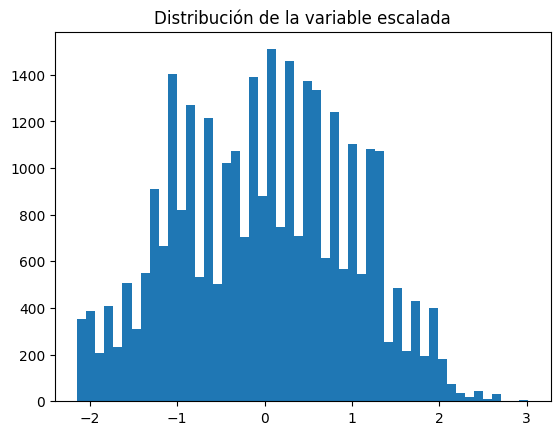

In [21]:
import matplotlib.pyplot as plt

# Histograma de la variable escalada
plt.hist(x_test['Age'], bins=50)
plt.title('Distribución de la variable escalada')
plt.show()

# Histograma de la variable no escalada ---> usar de A´ngel


In [22]:
print('Estadísticas descriptivas de la variable escalada:')
print(x_test['Age'].describe())

print('Estadísticas descriptivas de la variable escalada:')
#print(x_test_scaled[:, 0]).describe()) 

Estadísticas descriptivas de la variable escalada:
count    31079.000000
mean         0.000467
std          1.000278
min         -2.142578
25%         -0.819115
50%          0.041137
75%          0.769042
max          3.018930
Name: Age, dtype: float64
Estadísticas descriptivas de la variable escalada:


Primer modelo

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Crea un objeto RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrena el modelo con el conjunto de entrenamiento
model.fit(x_train, y_train)

# Evalúa el modelo con el conjunto de prueba
y_pred = model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

ValueError: could not convert string to float: 'Male'

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# ...

y_pred = model.predict(x_test)

# Calcula la accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# Calcula la precisión (average='weighted' for multi-class problems)
precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

# Calcula el recall
recall = recall_score(y_test, y_pred, average='weighted',labels=['neutral or dissatisfied', 'satisfied'])
print("Recall:", recall)

""" # Calcula el F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# Calcula el ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC:", roc_auc)

# Calcula la matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_mat) """

Multicolinealidad

Probando 

In [ ]:
""" 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import numpy as np


le = LabelEncoder()
y_train_le = le.fit_transform(y_train)

lin_reg = LinearRegression()
lin_reg.fit(x_train,y_train_le)


#print(x_train.head())
print(y_train.head())
print(lin_reg.predict(x_train.head()))

"""



""" 
El problema es que el modelo de regresión lineal (LinearRegression) no entiende que tu variable objetivo es binaria.

La regresión lineal es un algoritmo de aprendizaje automático que se utiliza para predecir valores continuos, no binarios. 
Cuando entrenas el modelo con tus datos, el algoritmo intenta encontrar la mejor línea que se ajuste a tus datos, pero no 
tiene en cuenta que la variable objetivo es binaria.

Por lo tanto, cuando haces print(lin_reg.predict(x_train.head())), el modelo devuelve valores decimales porque está tratando de predecir un valor continuo, no un valor binario.

Para solucionar este problema, debes utilizar un algoritmo de aprendizaje automático que sea adecuado para problemas de clasificación binaria, como LogisticRegression de scikit-learn. Este algoritmo entiende que la variable objetivo es binaria y devuelve probabilidades de pertenencia a cada clase, que puedes convertir en valores binarios (0 o 1) utilizando una función de umbral (threshold).

 """

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import numpy as np

""" # Codificaicón de la variable objetivo
le = LabelEncoder()
y_train_le = le.fit_transform(y_train) """


# Entrenamiento del modelo
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train_le)


# Predicción en el conjunto de prueba
y_test_le = le.transform(y_test)  # Codifica y_test para compararlo correctamente
y_pred = log_reg.predict(x_test)  # Predicción sobre el conjunto de prueba

# Evaluación del modelo
accuracy = accuracy_score(y_test_le, y_pred)
print("Accuracy:", accuracy)

# Ejemplo de predicciones sobre nuevas muestras (primeras 5 filas del conjunto de prueba)
print(x_test.head())
y_pred_example = log_reg.predict(x_test.head())
print(y_pred_example)



results_df = pd.DataFrame({
    'Real': y_test_le[:5],  # Primeras 5 filas reales
    'Predicción': y_pred_example # Primeras 5 predicciones
})

# Imprimir la tabla de resultados
print("\nValores reales vs. Predicciones:")
print(results_df)

En lugar de calcular la correlación entre las variables dummy, es más útil utilizar otras técnicas para seleccionar las variables más relevantes para el modelo. Algunas opciones son:

Análisis de la importancia de las características: utiliza algoritmos como Random Forest o Gradient Boosting para evaluar la importancia de cada variable en la predicción de Y.
Selección de características: utiliza técnicas como la selección recursiva de características (RFE) o la selección de características mediante la matriz de correlación de mutual information.
Análisis de la varianza: utiliza técnicas como la descomposición de la varianza para evaluar la contribución de cada variable a la varianza de Y.
Recuerda que la selección de variables es un paso importante en el proceso de modelado, y es importante utilizar técnicas adecuadas para identificar las variables más relevantes para el modelo.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Codificación de la variable objetivo
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)  # Codifica y_test para compararlo correctamente

# Entrenamiento del modelo
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train_le)

# Predicción en el conjunto de prueba
y_pred = log_reg.predict(x_test)  # Predicción sobre el conjunto de prueba

# Evaluación del modelo
accuracy = accuracy_score(y_test_le, y_pred)
print("Accuracy:", accuracy)




# Convertir las predicciones numéricas a etiquetas originales es por pura estética del 'satiesfied'
y_pred_example_labels = le.inverse_transform(y_pred_example)
print("\nPredicciones con etiquetas originales:")


y_test_example_labels = le.inverse_transform(y_test_le)


# Verificar si las predicciones son 'satisfied'
print("\n¿Las predicciones son 'satisfied'?")

# Mostrar los primeros 5 valores reales y predichos    
# Crear un DataFrame para mostrar los resultados
results_df = pd.DataFrame({
    'Real': y_test_example_labels[:5],  # Primeras 5 filas reales
    'Predicción': y_pred_example_labels[:5]  # Primeras 5 predicciones
})

# Imprimir la tabla de resultados
print("\nValores reales vs. Predicciones:")
print(results_df)

Voy a usar más métricas

In [ ]:
from sklearn.metrics import confusion_matrix
#
# Generar la matriz de confusión
cm = confusion_matrix(y_test_le, y_pred)

print("Matriz de Confusión:")
print(cm)

La matriz de confusión saca sus resultados a partir de lo parte de 'test', en general (pero se puede hacer una matriz de confusión de la parte de 'train' para comparar con la matriz de 'test' y así encontrar señales de 'overfitting'. Esto lo haré luego)

Para interpretar esta matriz, debemos entender qué representan cada una de las celdas:

La diagonal principal (de arriba a la izquierda a abajo a la derecha) representa las observaciones que el modelo clasificó correctamente. En este caso, hay 15005 observaciones que el modelo clasificó como negativas (0) y realmente eran negativas, y 10665 observaciones que el modelo clasificó como positivas (1) y realmente eran positivas.
La celda superior derecha (1455) representa las observaciones que el modelo clasificó como positivas (1) pero realmente eran negativas (0). Estas son llamadas "falsos positivos" (FP).
La celda inferior izquierda (1500) representa las observaciones que el modelo clasificó como negativas (0) pero realmente eran positivas (1). Estas son llamadas "falsos negativos" (FN).
A partir de esta matriz de confusión, podemos sacar varias conclusiones:

Precisión: La precisión del modelo se puede calcular como la suma de las observaciones clasificadas correctamente (diagonal principal) dividida entre el total de observaciones. En este caso, la precisión es (15005 + 10665) / (15005 + 1455 + 1500 + 10665) ≈ 0.92. Esto significa que el modelo es capaz de clasificar correctamente alrededor del 92% de las observaciones.

Sensibilidad: La sensibilidad se refiere a la capacidad del modelo para detectar observaciones positivas (1). Se puede calcular como la cantidad de verdaderos positivos (TP) dividida entre la suma de verdaderos positivos y falsos negativos (FN). En este caso, la sensibilidad es 10665 / (10665 + 1500) ≈ 0.877. Esto significa que el modelo es capaz de detectar alrededor del 87.7% de las observaciones positivas.

Especificidad: La especificidad se refiere a la capacidad del modelo para detectar observaciones negativas (0). Se puede calcular como la cantidad de verdaderos negativos (TN) dividida entre la suma de verdaderos negativos y falsos positivos (FP). En este caso, la especificidad es 15005 / (15005 + 1455) ≈ 0.912. Esto significa que el modelo es capaz de detectar alrededor del 91.2% de las observaciones negativas.
En resumen, la matriz de confusión indica que el modelo de regresión logística tiene una buena precisión y especificidad, pero una sensibilidad moderada. Esto sugiere que el modelo es capaz de clasificar correctamente la mayoría de las observaciones, pero puede tener dificultades para detectar algunas observaciones positivas.

Mirar qué es sobreajuste y cómo medirlo

El 'overfitting' es un problema que ocurre cuando un modelo de machine learning se ajusta demasiado bien a los datos de entrenamiento, capturando tanto las relaciones como el ruido o patrones irrelevantes en los datos.
Como resultado, aunque el modelo tenga un alto rendimiento en los datos de entrenamiento, su capacidad de generalización a nuevos datos o datos de prueba deficiente, lo que conduce a un bajo rendimiento de estos últimos.


En el caso del Modelo de Regresión Logística, algunas señales para evaluar Overfitting podría ser:
* Alta precisión en el conjunto de entrenamiento y baja precisión en el conjunto de prueba.
* Matriz de confusión desequilibrada, donde el modelo clasifica correctamente en el conjunto de entrenamiento, pero falla significativamente en el conjunto de prueba.
* Curva ROC/AUC, donde el AUC en los datos de prueba es significativamente más bajo que en los datos de entrenamiento.


Por tanto, se pueden realizar las siguientes comprobaciones para evaluarlo:


:

* 1. Compara el rendimiento entre los datos de entrenamiento y prueba: Revisa las métricas de precisión (accuracy), precisión (precision), sensibilidad (recall), y el AUC en ambos conjuntos de datos. Si el rendimiento es mucho mejor en el conjunto de entrenamiento que en el conjunto de prueba, es una señal clara de overfitting.

In [ ]:
# Predicción en el conjunto de entrenamiento
y_train_pred = log_reg.predict(x_train)
train_accuracy = accuracy_score(y_train_le, y_train_pred)

print("Precisión en el conjunto de entrenamiento:", train_accuracy)
print("Precisión en el conjunto de prueba:", accuracy) 

* 2. Curva de aprendizaje: 
Podemos graficar el rendimiento del modelo en el conjunto de entrenamiento y prueba en función del número de muestras. Si la precisión en el conjunto de prueba se estabiliza a un nivel bajo y en el conjunto de entrenamiento es muy alta, esto es una indicación de overfitting.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

# Parámetros para la función learning_curve
train_sizes = np.linspace(0.1, 1.0, 10)  # Fracciones del conjunto de datos de entrenamiento que se usarán

# Generar curva de aprendizaje
train_sizes, train_scores, validation_scores = learning_curve(
    LogisticRegression(), 
    x_train, y_train_le, 
    train_sizes=train_sizes, 
    cv=5,  # Validación cruzada de 5 folds
    scoring='accuracy',  # Medimos la precisión del modelo
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Cálculo de la media y desviación estándar para la precisión de entrenamiento y validación
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Precisión en entrenamiento', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.plot(train_sizes, validation_scores_mean, label='Precisión en validación', color='green')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, color='green', alpha=0.2)

# Etiquetas y leyenda
plt.title('Curva de aprendizaje para Regresión Logística')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.legend(loc='best')

# Mostrar gráfico
plt.grid()
plt.show()


Pruebo otro Modelo

4. Preparación de los Algoritmos de ML

5. Seleccionar un modelo y entrénalo

6. Ajustar el modelo (optimización con hypermaprámetros, ensamblado)

7. Presentar la solución.

8. Desplegar y monitorizar